In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from utils import check_balance,visualize, creat_datasets, reset_graph, grid_serach, read_pick_file
from layers import  bln_layer, dense_layer
from callbacks import bln_callback , tensorboard_callback, create_callback_list, save_best_model_callback

In [2]:
tf.config.experimental_run_functions_eagerly(True)

In [3]:
tf.__version__

'2.1.0'

### Loading data

In [4]:
random_seed = 100
minibatch = 20
buffersize = 60000
number_valid_sampels = 5000 # number of validation data
epochs = 5
learning_rate = 0.001
# 2250 -> 1 (all of the training dataset),  1125 -> .5 (half of the training dataset) , 562  -> .2 of the training dataset
number_batches_train = 500 #number of batches to train, each batch of size minibatch parameter / 
number_batches_valid = 50 # number of batches to validate, each batch of size minibatch parameter
num_classes = 10

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
x_train.shape

(50000, 32, 32, 3)

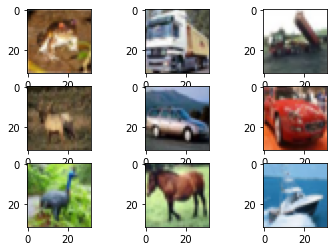

In [8]:
visualize(x_train)

In [9]:
train_dataset, valid_dataset, test_dataset = creat_datasets(x_train, y_train, x_test, y_test,
                                                            number_valid_sampels = number_valid_sampels,
                                                            random_seed = random_seed, minibatch = minibatch,
                                                            buffersize = buffersize, num_classes = num_classes,
                                                            reshape_to = 32*32*3, back_reshape = (-1,32,32,3))

#### Creating tf.data.Datasets

In [10]:
for i, j in valid_dataset.take(1) :
    print(i.shape, j.shape)


(20, 32, 32, 3) (20, 10)


# 1. Using Batch Layer Normalization Layer

In [11]:
def BLNLayer_model(inputshape= (32,32,3),
                    num_classes = 10, random_seed = 100,
                    batch_size = 60,
                    b_mm = True, b_mv = True,
                    f_mm = False, f_mv = False):
    
    # building the model
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=batch_size, name = 'input')
    
      
    x = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="same",
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed)) (input_lyr)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    x = bln_layer(stateful = True, batchsize= batch_size, name = 'bn1', 
                  batch_moving_mean = b_mm, batch_moving_var = b_mv,
                  feature_moving_mean = f_mm, feature_moving_var = f_mv)(x) 
    

    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed))(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    x = bln_layer(stateful = True, batchsize= batch_size, name = 'bn2', 
                  batch_moving_mean = b_mm, batch_moving_var = b_mv,
                  feature_moving_mean = f_mm, feature_moving_var = f_mv)(x)
      
  
    # flattening the convolutions
    x = tf.keras.layers.Flatten()(x)
    
    # fully-connected layer
    x = dense_layer(units = 120, name = 'dense1', random_seed=random_seed)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = bln_layer(stateful = True, batchsize= batch_size, name = 'bn3', 
                  batch_moving_mean = b_mm, batch_moving_var = b_mv,
                  feature_moving_mean = f_mm, feature_moving_var = f_mv)(x)
    
    x = dense_layer(units = 84, name = 'dense2', random_seed=random_seed)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = bln_layer(stateful = True, batchsize= batch_size, name = 'bn4', 
                  batch_moving_mean = b_mm, batch_moving_var = b_mv,
                  feature_moving_mean = f_mm, feature_moving_var = f_mv)(x)
                                  
    output_lyr = dense_layer(units = num_classes, name = 'dense3', random_seed=random_seed)(x)
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])


In [12]:
model_bln_layer = BLNLayer_model(inputshape = (32,32,3), 
                                 num_classes = num_classes,
                                 random_seed = random_seed,
                                 batch_size = minibatch,
                                 b_mm = True, b_mv = True,
                                 f_mm = False, f_mv = False,
                                )



In [13]:
model_bln_layer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(20, 32, 32, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (20, 32, 32, 6)           456       
_________________________________________________________________
average_pooling2d (AveragePo (20, 16, 16, 6)           0         
_________________________________________________________________
bn1 (bln_layer)              (20, 16, 16, 6)           13326     
_________________________________________________________________
conv2d_1 (Conv2D)            (20, 12, 12, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (20, 6, 6, 16)            0         
_________________________________________________________________
bn2 (bln_layer)              (20, 6, 6, 16)            2626  

# callbacks

In [14]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_bln_layer_TTFF_cifar10'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

# Callback for resetting moving mean and variances at the end of each epoch
bln_layer_cb = bln_callback()

bln_layer_cb_list = create_callback_list(save_bm_cb, tb_cb, bln_layer_cb)

In [15]:
model_bln_layer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [16]:
model_bln_layer_history =  model_bln_layer.fit(train_dataset.take(number_batches_train), epochs = epochs,
                                                verbose = 1, callbacks = bln_layer_cb_list,
                                                validation_data = valid_dataset.take(number_batches_valid),
                                                shuffle = True)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 23s 47ms/step - loss: 1.9314 - categorical_accuracy: 0.3259 - val_loss: 2.0588 - val_categorical_accuracy: 0.2400
Epoch 2/5
500/500 [==============================] - 22s 44ms/step - loss: 1.6934 - categorical_accuracy: 0.4014 - val_loss: 1.9237 - val_categorical_accuracy: 0.3210
Epoch 3/5
500/500 [==============================] - 23s 45ms/step - loss: 1.5480 - categorical_accuracy: 0.4433 - val_loss: 1.5222 - val_categorical_accuracy: 0.4630
Epoch 4/5
500/500 [==============================] - 23s 45ms/step - loss: 1.4263 - categorical_accuracy: 0.4892 - val_loss: 1.4090 - val_categorical_accuracy: 0.4910
Epoch 5/5
500/500 [==============================] - 23s 45ms/step - loss: 1.3150 - categorical_accuracy: 0.5269 - val_loss: 1.3992 - val_categorical_accuracy: 0.4980


In [18]:
weights_path = "./models/" + folder_name + '/'+ str(number_batches_train) +"_pretrained_weights_TTFF.h5"
model_bln_layer.save_weights(weights_path)

In [19]:
del model_bln_layer, save_bm_cb, tb_cb, bln_layer_cb, bln_layer_cb_list
reset_graph()

session is clear


In [20]:
save_eval_path = "./logs/" + folder_name + '/'+ str(number_batches_train) +"_sorted_evaluation.pkl"
evaluation = grid_serach(BLNLayer_model, test_dataset,
                         batch_size = minibatch, sort=True, 
                         save_eval_path = save_eval_path,
                         weights_path = weights_path)


500/500 [==============================] - 7s 14ms/step - loss: 1.4449 - categorical_accuracy: 0.4820
{'Bmm_True Bmv_True Fmm_True Fmv_True': [1.4449374260902406, 0.482]}
session is clear
500/500 [==============================] - 8s 15ms/step - loss: 1.4427 - categorical_accuracy: 0.4845
{'Bmm_True Bmv_True Fmm_True Fmv_True': [1.4449374260902406, 0.482], 'Bmm_True Bmv_True Fmm_True Fmv_False': [1.4426605182886123, 0.4845]}
session is clear
500/500 [==============================] - 7s 14ms/step - loss: 1.4503 - categorical_accuracy: 0.4804
{'Bmm_True Bmv_True Fmm_True Fmv_True': [1.4449374260902406, 0.482], 'Bmm_True Bmv_True Fmm_True Fmv_False': [1.4426605182886123, 0.4845], 'Bmm_True Bmv_True Fmm_False Fmv_True': [1.4502934346199035, 0.4804]}
session is clear
500/500 [==============================] - 7s 14ms/step - loss: 1.4502 - categorical_accuracy: 0.4809
{'Bmm_True Bmv_True Fmm_True Fmv_True': [1.4449374260902406, 0.482], 'Bmm_True Bmv_True Fmm_True Fmv_False': [1.442660518288

500/500 [==============================] - 8s 15ms/step - loss: 1.4896 - categorical_accuracy: 0.4700
{'Bmm_True Bmv_True Fmm_True Fmv_True': [1.4449374260902406, 0.482], 'Bmm_True Bmv_True Fmm_True Fmv_False': [1.4426605182886123, 0.4845], 'Bmm_True Bmv_True Fmm_False Fmv_True': [1.4502934346199035, 0.4804], 'Bmm_True Bmv_True Fmm_False Fmv_False': [1.4502008731365204, 0.4809], 'Bmm_True Bmv_False Fmm_True Fmv_True': [1.581213408589363, 0.4567], 'Bmm_True Bmv_False Fmm_True Fmv_False': [1.578418161034584, 0.4572], 'Bmm_True Bmv_False Fmm_False Fmv_True': [1.5906359684467315, 0.4556], 'Bmm_True Bmv_False Fmm_False Fmv_False': [1.5924552661180496, 0.4564], 'Bmm_False Bmv_True Fmm_True Fmv_True': [1.4744895055294036, 0.4786], 'Bmm_False Bmv_True Fmm_True Fmv_False': [1.4732348175048828, 0.4797], 'Bmm_False Bmv_True Fmm_False Fmv_True': [1.4770033667087554, 0.4753], 'Bmm_False Bmv_True Fmm_False Fmv_False': [1.4766154220104217, 0.4758], 'Bmm_False Bmv_False Fmm_True Fmv_True': [1.48901310

In [21]:
evaluation#

[('Bmm_True Bmv_True Fmm_True Fmv_False', [1.4426605182886123, 0.4845]),
 ('Bmm_True Bmv_True Fmm_True Fmv_True', [1.4449374260902406, 0.482]),
 ('Bmm_True Bmv_True Fmm_False Fmv_False', [1.4502008731365204, 0.4809]),
 ('Bmm_True Bmv_True Fmm_False Fmv_True', [1.4502934346199035, 0.4804]),
 ('Bmm_False Bmv_True Fmm_True Fmv_False', [1.4732348175048828, 0.4797]),
 ('Bmm_False Bmv_True Fmm_True Fmv_True', [1.4744895055294036, 0.4786]),
 ('Bmm_False Bmv_True Fmm_False Fmv_False', [1.4766154220104217, 0.4758]),
 ('Bmm_False Bmv_True Fmm_False Fmv_True', [1.4770033667087554, 0.4753]),
 ('Bmm_False Bmv_False Fmm_True Fmv_True', [1.4890131040811538, 0.4703]),
 ('Bmm_False Bmv_False Fmm_True Fmv_False', [1.4894078072309493, 0.4716]),
 ('Bmm_False Bmv_False Fmm_False Fmv_True', [1.4896104557514191, 0.47]),
 ('Bmm_False Bmv_False Fmm_False Fmv_False', [1.4900298979282378, 0.4701]),
 ('Bmm_True Bmv_False Fmm_True Fmv_False', [1.578418161034584, 0.4572]),
 ('Bmm_True Bmv_False Fmm_True Fmv_True', 

# 2.Using  Batch Normalization implemented in Keras

In [22]:
def bn_keras_model(inputshape= (32,32,3), 
                    num_classes = 10,
                    random_seed = 100,
                    batch_size = 60):
    
    # building the model
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=batch_size, name = 'input')
    
    x = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="same",
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed)) (input_lyr)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization(momentum = 0.99, name = 'bn1')(x) 

    

    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed))(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization(momentum = 0.99, name = 'bn2')(x) 

      
  
    # flattening the convolutions
    x = tf.keras.layers.Flatten()(x)
    
    # fully-connected layer
    x = dense_layer(units = 120, name = 'dense1', random_seed=random_seed)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.BatchNormalization(momentum = 0.99, name = 'bn3')(x) 

    
    x = dense_layer(units = 84, name = 'dense2', random_seed=random_seed)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.BatchNormalization(momentum = 0.99, name = 'bn4')(x) 

                                  
    output_lyr = dense_layer(units = num_classes, name = 'dense3', random_seed=random_seed)(x)
   
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])


In [23]:
model_bn_keras = bn_keras_model(inputshape= (32,32,3), 
                                num_classes = 10, random_seed = 100,
                                batch_size = minibatch)
model_bn_keras.summary()

#### Compiling 
model_bn_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(20, 32, 32, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (20, 32, 32, 6)           456       
_________________________________________________________________
average_pooling2d (AveragePo (20, 16, 16, 6)           0         
_________________________________________________________________
bn1 (BatchNormalization)     (20, 16, 16, 6)           24        
_________________________________________________________________
conv2d_1 (Conv2D)            (20, 12, 12, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (20, 6, 6, 16)            0         
_________________________________________________________________
bn2 (BatchNormalization)     (20, 6, 6, 16)            64    

In [24]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_bn_Keras_cifar10'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

bn_keras_cb_list = [save_bm_cb, tb_cb]

In [25]:
model_bn_keras_history =  model_bn_keras.fit(train_dataset.take(number_batches_train),
                                             epochs=epochs, verbose=1, 
                                             callbacks=bn_keras_cb_list,
                                             validation_data=valid_dataset.take(number_batches_valid),
                                             shuffle=True)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 14s 28ms/step - loss: 1.9416 - categorical_accuracy: 0.3189 - val_loss: 1.7692 - val_categorical_accuracy: 0.3580
Epoch 2/5
500/500 [==============================] - 14s 28ms/step - loss: 1.7052 - categorical_accuracy: 0.3980 - val_loss: 1.6246 - val_categorical_accuracy: 0.4090
Epoch 3/5
500/500 [==============================] - 14s 29ms/step - loss: 1.5487 - categorical_accuracy: 0.4537 - val_loss: 1.5703 - val_categorical_accuracy: 0.4190
Epoch 4/5
500/500 [==============================] - 14s 28ms/step - loss: 1.4039 - categorical_accuracy: 0.5067 - val_loss: 1.5072 - val_categorical_accuracy: 0.4600
Epoch 5/5
500/500 [==============================] - 14s 27ms/step - loss: 1.2718 - categorical_accuracy: 0.5530 - val_loss: 1.5220 - val_categorical_accuracy: 0.4460


In [26]:
model_bn_keras_test_history  = model_bn_keras.evaluate(test_dataset)

500/500 [==============================] - 5s 11ms/step - loss: 1.5601 - categorical_accuracy: 0.4521


In [27]:
del model_bn_keras, save_bm_cb, tb_cb, bn_keras_cb_list 
reset_graph()

session is clear


# 3.Using  Layer normalization  implemented in Keras

In [28]:
def ln_keras_model(inputshape= (32,32,3), units1 = 512,
                    num_classes = 10, random_seed = 100,
                    batch_size = 60):
    
    # building the model
    
  # building the model
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=batch_size, name = 'input')
    
    x = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="same",
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed)) (input_lyr)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.LayerNormalization()(x) 

    

    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed))(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.LayerNormalization()(x) 

      
  
    # flattening the convolutions
    x = tf.keras.layers.Flatten()(x)
    
    # fully-connected layer
    x = dense_layer(units = 120, name = 'dense1', random_seed=random_seed)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.LayerNormalization()(x) 

    
    x = dense_layer(units = 84, name = 'dense2', random_seed=random_seed)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.LayerNormalization()(x) 
                                  
    output_lyr = dense_layer(units = num_classes, name = 'dense3', random_seed=random_seed)(x)
   
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])


In [29]:
model_ln_keras = ln_keras_model(inputshape= (32,32,3), 
                                num_classes = 10, random_seed = 100,
                                batch_size = minibatch)
model_ln_keras.summary()

#### Compiling 
model_ln_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(20, 32, 32, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (20, 32, 32, 6)           456       
_________________________________________________________________
average_pooling2d (AveragePo (20, 16, 16, 6)           0         
_________________________________________________________________
layer_normalization (LayerNo (20, 16, 16, 6)           12        
_________________________________________________________________
conv2d_1 (Conv2D)            (20, 12, 12, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (20, 6, 6, 16)            0         
_________________________________________________________________
layer_normalization_1 (Layer (20, 6, 6, 16)            32    

In [30]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_ln_Keras_cifar10'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

ln_keras_cb_list = [save_bm_cb, tb_cb]

In [31]:
model_ln_keras_history =  model_ln_keras.fit(train_dataset.take(number_batches_train),
                                             epochs=epochs, verbose=1, 
                                             callbacks=ln_keras_cb_list,
                                             validation_data=valid_dataset.take(number_batches_valid),
                                             shuffle=True)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 13s 26ms/step - loss: 1.9044 - categorical_accuracy: 0.3311 - val_loss: 1.7253 - val_categorical_accuracy: 0.3690
Epoch 2/5
500/500 [==============================] - 13s 26ms/step - loss: 1.6629 - categorical_accuracy: 0.4166 - val_loss: 1.6636 - val_categorical_accuracy: 0.3910
Epoch 3/5
500/500 [==============================] - 13s 26ms/step - loss: 1.5235 - categorical_accuracy: 0.4737 - val_loss: 1.6418 - val_categorical_accuracy: 0.4080
Epoch 4/5
500/500 [==============================] - 14s 27ms/step - loss: 1.4048 - categorical_accuracy: 0.5172 - val_loss: 1.6339 - val_categorical_accuracy: 0.4100
Epoch 5/5
500/500 [==============================] - 13s 26ms/step - loss: 1.2923 - categorical_accuracy: 0.5573 - val_loss: 1.6623 - val_categorical_accuracy: 0.4010


In [32]:
model_ln_keras_test_history = model_ln_keras.evaluate(test_dataset)

500/500 [==============================] - 6s 13ms/step - loss: 1.7013 - categorical_accuracy: 0.4143


In [33]:
del model_ln_keras,save_bm_cb, ln_keras_cb_list
reset_graph()

session is clear


# 4. Make Comaprison
#### Layer Normalization, Batch Normalization and Batch Layer Normalization

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


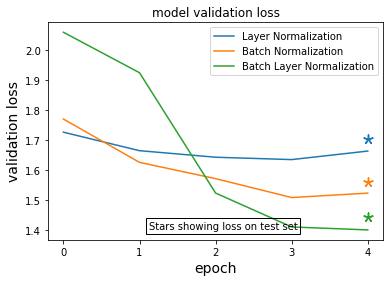

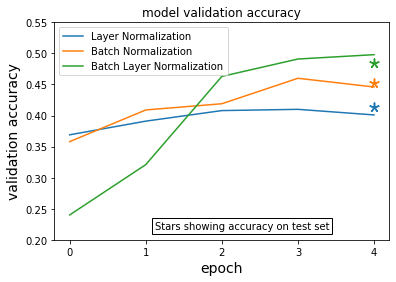

In [55]:
# list all data in history
print(model_ln_keras_history.history.keys())
# summarize history for accuracy


plt.figsize=(12, 12)
plt.plot(model_ln_keras_history.history['val_loss'])
plt.plot(model_bn_keras_history.history['val_loss'])
plt.plot(model_bln_layer_history.history['val_loss'])
plt.scatter(4, model_ln_keras_test_history[0], s=80,  marker=(5, 2))
plt.scatter(4, model_bn_keras_test_history[0], s=80,  marker=(5, 2))
plt.scatter(4,evaluation[0][1][0], s=80,  marker=(5, 2))
plt.xticks(np.arange(0, 5, 1))

plt.title('model validation loss')
plt.ylabel('validation loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['Layer Normalization', 'Batch Normalization','Batch Layer Normalization' ], loc='upper right')
ax = plt.gca()
ax.text(0.3,0.05,'Stars showing loss on test set',transform=ax.transAxes, bbox=dict(facecolor='none',edgecolor='black',boxstyle='square'))
plt.show()


plt.plot(model_ln_keras_history.history['val_categorical_accuracy'])
plt.plot(model_bn_keras_history.history['val_categorical_accuracy'])
plt.plot(model_bln_layer_history.history['val_categorical_accuracy'])
plt.scatter(4, model_ln_keras_test_history[1], s=80,  marker=(5, 2))
plt.scatter(4, model_bn_keras_test_history[1], s=80,  marker=(5, 2))
plt.scatter(4, evaluation[0][1][1], s=80,  marker=(5, 2))
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0.2, .6, .05))

plt.title('model validation accuracy')
plt.ylabel('validation accuracy', fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['Layer Normalization', 'Batch Normalization','Batch Layer Normalization' ], loc='upper left')
ax = plt.gca()
ax.text(0.3,0.05,'Stars showing accuracy on test set',transform=ax.transAxes, bbox=dict(facecolor='none',edgecolor='black',boxstyle='square'))
plt.show()



# 5.The behavior of The Numerator of Equation. 7

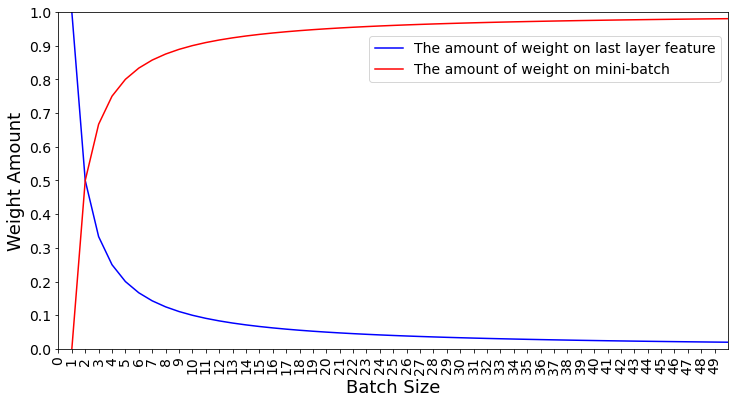

In [41]:
f,b = [], []
for i in range(50):
    b.append([i+1,1- (1/(i+1))+.0001])
    f.append([i+1,1/(i+1)-.0001])

f =  np.array(f)#shape
b =  np.array(b)#shape

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(f[:,:1], f[:,1:], color='blue')
ax.plot(b[:,:1], b[:,1:], color='red')

plt.xlim([0, 50])
plt.ylim([0, 1])
plt.xticks(np.arange(0, 50, 1.0))
plt.xticks(fontsize=14, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.yticks(fontsize=14)

plt.xlabel('Batch Size',  fontsize=18)
fig.subplots_adjust(bottom=0.1)
plt.ylabel('Weight Amount',  fontsize=18)
plt.legend(["The amount of weight on last layer feature",   "The amount of weight on mini-batch "],
           bbox_to_anchor=(1.00, .95), loc='upper right', fontsize=14)

plt.show()